<a href="https://colab.research.google.com/github/scobb052/predictive-modeling-portfolio/blob/main/performance%2Bmetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-learn aif360 pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
# Create synthetic data (100 patients)
np.random.seed(42)
data = pd.DataFrame({
    'age': np.random.randint(30, 80, 100),
    'sex': np.random.choice(['male', 'female'], 100),  # Sensitive attribute
    'predicted_high_risk': np.random.choice([0, 1], 100),  # Model output
    'actual_high_risk': np.random.choice([0, 1], 100)  # True risk
})

# Convert sex to binary: male=1, female=0
data['sex_binary'] = data['sex'].apply(lambda x: 1 if x == 'male' else 0)

print(data.head())

   age     sex  predicted_high_risk  actual_high_risk  sex_binary
0   68    male                    1                 1           1
1   58  female                    1                 0           0
2   44    male                    0                 1           1
3   72  female                    1                 0           0
4   37  female                    0                 1           0


In [4]:
# Compute positive prediction rates for each group
male_rate = data[data['sex_binary'] == 1]['predicted_high_risk'].mean()
female_rate = data[data['sex_binary'] == 0]['predicted_high_risk'].mean()

print(f"Male Positive Prediction Rate: {male_rate:.2f}")
print(f"Female Positive Prediction Rate: {female_rate:.2f}")

# Demographic Parity Difference
demographic_parity_diff = abs(male_rate - female_rate)
print(f"Demographic Parity Difference: {demographic_parity_diff:.2f}")


Male Positive Prediction Rate: 0.49
Female Positive Prediction Rate: 0.51
Demographic Parity Difference: 0.02


In [5]:
# Compute confusion matrices
cm_male = confusion_matrix(data[data['sex_binary'] == 1]['actual_high_risk'],
                           data[data['sex_binary'] == 1]['predicted_high_risk'])

cm_female = confusion_matrix(data[data['sex_binary'] == 0]['actual_high_risk'],
                             data[data['sex_binary'] == 0]['predicted_high_risk'])

# Extract TP, FP, FN, TN
TPR_male = cm_male[1, 1] / (cm_male[1, 1] + cm_male[1, 0])  # Sensitivity
FPR_male = cm_male[0, 1] / (cm_male[0, 1] + cm_male[0, 0])  # False Alarm

TPR_female = cm_female[1, 1] / (cm_female[1, 1] + cm_female[1, 0])
FPR_female = cm_female[0, 1] / (cm_female[0, 1] + cm_female[0, 0])

# Print results
print(f"Male TPR: {TPR_male:.2f}, Male FPR: {FPR_male:.2f}")
print(f"Female TPR: {TPR_female:.2f}, Female FPR: {FPR_female:.2f}")

# Equalized Odds Difference
TPR_diff = abs(TPR_male - TPR_female)
FPR_diff = abs(FPR_male - FPR_female)

print(f"Equalized Odds Difference (TPR): {TPR_diff:.2f}")
print(f"Equalized Odds Difference (FPR): {FPR_diff:.2f}")


Male TPR: 0.43, Male FPR: 0.56
Female TPR: 0.62, Female FPR: 0.35
Equalized Odds Difference (TPR): 0.18
Equalized Odds Difference (FPR): 0.20


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Generate synthetic probabilities (simulating model output)
np.random.seed(42)
data['predicted_proba'] = np.random.uniform(0, 1, 100)  # Simulating predicted probabilities

# Compute ROC curves separately for males and females
male_data = data[data['sex_binary'] == 1]
female_data = data[data['sex_binary'] == 0]

fpr_male, tpr_male, thresholds_male = roc_curve(male_data['actual_high_risk'], male_data['predicted_proba'])
fpr_female, tpr_female, thresholds_female = roc_curve(female_data['actual_high_risk'], female_data['predicted_proba'])


In [10]:
thresholds_female


array([       inf, 0.98688694, 0.96958463, 0.96563203, 0.95071431,
       0.82873751, 0.80839735, 0.80219698, 0.78517596, 0.76078505,
       0.5612772 , 0.52273283, 0.52006802, 0.42754102, 0.36636184,
       0.32518332, 0.31098232, 0.30461377, 0.30424224, 0.15601864,
       0.15599452, 0.07455064, 0.07404465, 0.02541913, 0.02058449])

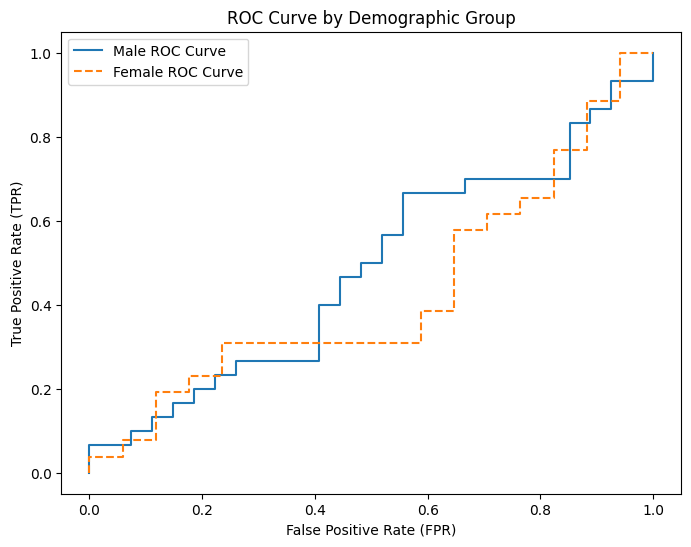

In [11]:

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_male, tpr_male, label="Male ROC Curve")
plt.plot(fpr_female, tpr_female, label="Female ROC Curve", linestyle="dashed")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve by Demographic Group")
plt.legend()
plt.show()


In [12]:
# Find thresholds that give equalized odds
def find_threshold_for_equal_tpr(fpr, tpr, thresholds, target_tpr):
    """Finds the threshold that gets closest to the target TPR."""
    idx = np.argmin(np.abs(tpr - target_tpr))
    return thresholds[idx]

# Set target TPR (e.g., making both groups have the same sensitivity)
target_tpr = 0.75

male_threshold = find_threshold_for_equal_tpr(fpr_male, tpr_male, thresholds_male, target_tpr)
female_threshold = find_threshold_for_equal_tpr(fpr_female, tpr_female, thresholds_female, target_tpr)

print(f"Adjusted Male Threshold: {male_threshold:.2f}")
print(f"Adjusted Female Threshold: {female_threshold:.2f}")


Adjusted Male Threshold: 0.27
Adjusted Female Threshold: 0.16


In [13]:
# Apply new thresholds
data['adjusted_predicted'] = data.apply(
    lambda row: 1 if row['predicted_proba'] >= male_threshold and row['sex_binary'] == 1 else
                (1 if row['predicted_proba'] >= female_threshold and row['sex_binary'] == 0 else 0),
    axis=1
)

# Compute new TPR & FPR
cm_male_new = confusion_matrix(data[data['sex_binary'] == 1]['actual_high_risk'],
                               data[data['sex_binary'] == 1]['adjusted_predicted'])

cm_female_new = confusion_matrix(data[data['sex_binary'] == 0]['actual_high_risk'],
                                 data[data['sex_binary'] == 0]['adjusted_predicted'])

TPR_male_new = cm_male_new[1, 1] / (cm_male_new[1, 1] + cm_male_new[1, 0])
FPR_male_new = cm_male_new[0, 1] / (cm_male_new[0, 1] + cm_male_new[0, 0])

TPR_female_new = cm_female_new[1, 1] / (cm_female_new[1, 1] + cm_female_new[1, 0])
FPR_female_new = cm_female_new[0, 1] / (cm_female_new[0, 1] + cm_female_new[0, 0])

print(f"Adjusted Male TPR: {TPR_male_new:.2f}, Adjusted Male FPR: {FPR_male_new:.2f}")
print(f"Adjusted Female TPR: {TPR_female_new:.2f}, Adjusted Female FPR: {FPR_female_new:.2f}")

TPR_diff_new = abs(TPR_male_new - TPR_female_new)
FPR_diff_new = abs(FPR_male_new - FPR_female_new)

print(f"New Equalized Odds Difference (TPR): {TPR_diff_new:.2f}")
print(f"New Equalized Odds Difference (FPR): {FPR_diff_new:.2f}")


Adjusted Male TPR: 0.70, Adjusted Male FPR: 0.67
Adjusted Female TPR: 0.77, Adjusted Female FPR: 0.82
New Equalized Odds Difference (TPR): 0.07
New Equalized Odds Difference (FPR): 0.16
